In [1]:
import torch
import pandas as pd
from TorchDataUtils import *
from NLPDataUtils import *

%matplotlib notebook
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Clasificación sin WordVectors

In [4]:
class AGNewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root='./AG_NEWS/', preprocess=lambda x: x, train=True):
        
        target = 'train.csv' if train else 'test.csv'
        df = pd.read_csv(root + target, header=None, names=['class_idx', 'title', 'description'])
        
        # Etiquetas:
        self.cls_indeces = torch.tensor(df['class_idx'].tolist(), dtype=torch.long) - 1
        
        # DataSeries con las muestras de entradas:
        data = df['title']
        self.data = preprocess(data)
    
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        return self.vectorizer.vectorize(self.data.iloc[idx]), self.cls_indeces[idx]
    
    def __len__(self):
        return len(self.cls_indeces)
    
    
def GetAGNewsDataset(root, preprocess, cutoff=25):
    
    # Datasets:
    train_dataset = AGNewsDataset(root, preprocess=preprocess, train=True)
    train_dataset.vectorizer = Vectorizer([train_dataset.data], cutoff=cutoff)
    test_dataset = AGNewsDataset(root, preprocess=preprocess, train=False)
    test_dataset.vectorizer = train_dataset.vectorizer
    
    # Dataloaders:
    train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset, 
                                                                              test_dataset,    
                                                                              batch_size=64)
    return train_dataloader, val_dataloader, test_dataloader

def preprocess(data):
    df = data.str.replace(r'\(AP\)','')
    df = df.str.replace(r'\(Reuters\)','')
    df = df.str.replace(r'\(AFP\)','')
    df = df.str.replace(r'\(SPACE\.com\)','')
    df = df.str.replace(r'\ba\b','')
    df = df.str.replace(r'\bthe\b','')
    df = df.str.replace(r'\bis\b','')
    df = df.str.replace(r'\bof\b','')
    df = df.str.replace(r'\bto\b','')
    df = df.str.replace(r'[,:;\?\!\"]','')
    df = df.str.replace(r'\s+','<SEP>')
    df = df.str.replace(r"'s<SEP>","<SEP>'s<SEP>")
    df = df.str.split('<SEP>')
    return df

In [5]:
tc_train_dataloader, tc_val_dataloader, tc_test_dataloader = GetAGNewsDataset(root='./AG_NEWS/', 
                                                                     preprocess=preprocess, 
                                                                     cutoff=25)

import torch.nn as nn

class TextClassifier1(nn.Module):
    
    def __init__(self, vocab_size, n_embeddings, n_classes):
        super(TextClassifier1, self).__init__()
        self.emb = nn.Linear(vocab_size, n_embeddings)
        self.out = nn.Linear(n_embeddings, n_classes)
        
    def forward(self, x):
        return self.out(self.emb(x))
    
    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss()
        return lf(scores, target)

In [7]:
# Parámetros de las muestras:
data = {
    'use_gpu': True, # Trasladar o no las muestras a la GPU
    'input_dtype': torch.float, # Tipo de dato de las muestras de entrada
    'target_dtype': torch.long, # Tipo de dato de las muestras de salida
    'train_dataloader': tc_train_dataloader, # Dataset de entrenamiento
    'val_dataloader': tc_val_dataloader # Dataset de validación
}

# Parámetros de optimización:
epochs = 20 # Cantidad de epochs
sample_loss_every = 500 # Cantidad de iteraciones para calcular la cantidad de aciertos
learning_rate = [1, 5e-1] # Tasa de aprendizaje
check_on_train = False # Queremos ver los resultados también en el train set

# Entrenamiento:
performance_history = []
classification_models = []

vocab_size = len(tc_train_dataloader.dataset.vectorizer.vocabulary)
n_classes = 4
n_embeddings = 100
ClassifierModel = TextClassifier1(vocab_size, n_embeddings, n_classes)

for lr in learning_rate:
    model = TextClassifier1(vocab_size, n_embeddings, n_classes)
    model.load_state_dict(ClassifierModel.state_dict())
    performance_history.append(SGDTrainModel(model, 
                                             data, 
                                             epochs, 
                                             lr, 
                                             sample_loss_every, 
                                             check_on_train, 
                                             verbose=True))
    classification_models.append(model)
    print('lr={:.2g} completed.'.format(lr))

Epoch: 0, Batch number: 0
Accuracy on validation dataset: 645/2400 (26.88%)

Epoch: 0, Batch number: 500
Accuracy on validation dataset: 1585/2400 (66.04%)

Epoch: 0, Batch number: 1000
Accuracy on validation dataset: 1914/2400 (79.75%)

Epoch: 0, Batch number: 1500
Accuracy on validation dataset: 1911/2400 (79.62%)

Epoch: 1, Batch number: 162
Accuracy on validation dataset: 1917/2400 (79.88%)

Epoch: 1, Batch number: 662
Accuracy on validation dataset: 1922/2400 (80.08%)

Epoch: 1, Batch number: 1162
Accuracy on validation dataset: 1897/2400 (79.04%)

Epoch: 1, Batch number: 1662
Accuracy on validation dataset: 1942/2400 (80.92%)

Epoch: 2, Batch number: 324
Accuracy on validation dataset: 1926/2400 (80.25%)

Epoch: 2, Batch number: 824
Accuracy on validation dataset: 1844/2400 (76.83%)

Epoch: 2, Batch number: 1324
Accuracy on validation dataset: 1940/2400 (80.83%)

Epoch: 2, Batch number: 1824
Accuracy on validation dataset: 1921/2400 (80.04%)

Epoch: 3, Batch number: 486
Accuracy 

Epoch: 7, Batch number: 1134
Accuracy on validation dataset: 1938/2400 (80.75%)

Epoch: 7, Batch number: 1634
Accuracy on validation dataset: 1943/2400 (80.96%)

Epoch: 8, Batch number: 296
Accuracy on validation dataset: 1938/2400 (80.75%)

Epoch: 8, Batch number: 796
Accuracy on validation dataset: 1946/2400 (81.08%)

Epoch: 8, Batch number: 1296
Accuracy on validation dataset: 1914/2400 (79.75%)

Epoch: 8, Batch number: 1796
Accuracy on validation dataset: 1946/2400 (81.08%)

Epoch: 9, Batch number: 458
Accuracy on validation dataset: 1938/2400 (80.75%)

Epoch: 9, Batch number: 958
Accuracy on validation dataset: 1931/2400 (80.46%)

Epoch: 9, Batch number: 1458
Accuracy on validation dataset: 1937/2400 (80.71%)

Epoch: 10, Batch number: 120
Accuracy on validation dataset: 1957/2400 (81.54%)

Epoch: 10, Batch number: 620
Accuracy on validation dataset: 1943/2400 (80.96%)

Epoch: 10, Batch number: 1120
Accuracy on validation dataset: 1939/2400 (80.79%)

Epoch: 10, Batch number: 1620
A

<IPython.core.display.Javascript object>


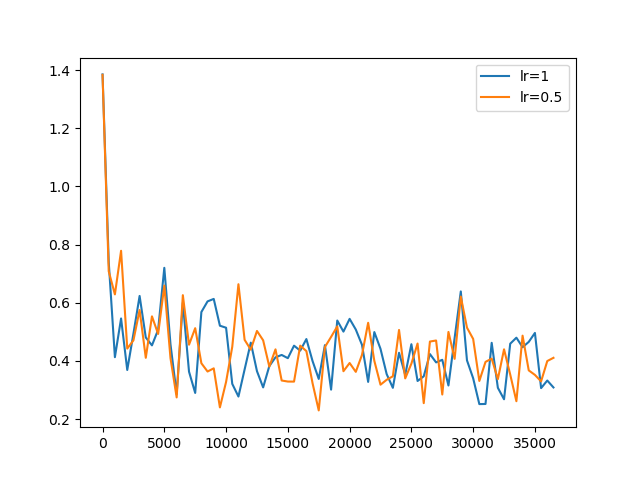

In [8]:
fig, ax = plt.subplots()
for lr, ph in zip(learning_rate, performance_history):
    ax.plot(ph['iter'],ph['loss'],label='lr={:.2g}'.format(lr))
    
ax.legend()

# Entrenamiento de word vectors para clasificación

## Pretraining

In [9]:
class WordEmbeddingAGNewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root='./AG_NEWS/', preprocess=lambda x: x, n_window=2, train=True):
        
        target = 'train.csv' if train else 'test.csv'
        df = pd.read_csv(root + target, header=None, names=['class_idx', 'title', 'description'])
        data = preprocess(df['title'])
        samples = data.apply(self._get_context, n_window=n_window)
        self.data = pd.DataFrame([[subsample[0], subsample[1]] for sample in samples for subsample in sample],
                                 columns=['word','context'])
    
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        context_vector = self.vectorizer.vectorize(self.data['context'].iloc[idx])
        word_index = self.vectorizer.vocabulary.token_to_index(self.data['word'].iloc[idx])
        return context_vector, word_index
    
    def _get_context(self,sentence,n_window):
        
        no_sentence = '<NS>'
        samples = []
        for i, word in enumerate(sentence):
            first_context_word_index = max(0,i-n_window)
            last_context_word_index = min(i+n_window+1, len(sentence))

            context = [no_sentence for j in range(i-n_window,first_context_word_index)] + \
                      sentence[first_context_word_index:i] + \
                      sentence[i+1:last_context_word_index] + \
                      [no_sentence for j in range(last_context_word_index,i+n_window+1)]
            
            samples.append((word,context))

        return samples
    
    
    def __len__(self):
        return len(self.data)
    
    
def GetAGNewsWordEmbeddingsDataset(root, preprocess, n_window=2, cutoff=25):
    
    # Datasets:
    train_dataset = WordEmbeddingAGNewsDataset(root, preprocess=preprocess, n_window=2, train=True)
    train_dataset.vectorizer = Vectorizer([train_dataset.data['word']], cutoff=cutoff)
    test_dataset = WordEmbeddingAGNewsDataset(root, preprocess=preprocess, n_window=2, train=False)
    test_dataset.vectorizer = train_dataset.vectorizer
    
    # Dataloaders:
    train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset, 
                                                                              test_dataset,    
                                                                              batch_size=64)
    return train_dataloader, val_dataloader, test_dataloader


def preprocess(data):
    df = data.str.replace(r'\(AP\)','')
    df = df.str.replace(r'\(Reuters\)','')
    df = df.str.replace(r'\(AFP\)','')
    df = df.str.replace(r'\(SPACE\.com\)','')
    df = df.str.replace(r'\ba\b','')
    df = df.str.replace(r'\bthe\b','')
    df = df.str.replace(r'\bis\b','')
    df = df.str.replace(r'\bof\b','')
    df = df.str.replace(r'\bto\b','')
    df = df.str.replace(r'[,:;\?\!\"]','')
    df = df.str.replace(r'\s+','<SEP>')
    df = df.str.replace(r"'s<SEP>","<SEP>'s<SEP>")
    df = df.str.split('<SEP>')
    return df


we_train_dataloader, we_val_dataloader, we_test_dataloader = GetAGNewsWordEmbeddingsDataset(root='./AG_NEWS/', 
                                                                               preprocess=preprocess, 
                                                                               cutoff=25)

In [10]:
import torch.nn as nn

class Word2VecCBOW(nn.Module):
    
    def __init__(self, vocab_size, n_embeddings):
        super(Word2VecCBOW, self).__init__()
        self.emb = nn.Linear(vocab_size, n_embeddings)
        self.out = nn.Linear(n_embeddings, vocab_size)
        
    def forward(self, x):
        return self.out(self.emb(x))
    
    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss()
        return lf(scores, target)

In [11]:
# Parámetros de las muestras:
data = {
    'use_gpu': True, # Trasladar o no las muestras a la GPU
    'input_dtype': torch.float, # Tipo de dato de las muestras de entrada
    'target_dtype': torch.long, # Tipo de dato de las muestras de salida
    'train_dataloader': we_train_dataloader, # Dataset de entrenamiento
    'val_dataloader': we_val_dataloader # Dataset de validación
}

# Parámetros de optimización:
epochs = 40 # Cantidad de epochs
sample_loss_every = 7500 # Cantidad de iteraciones para calcular la cantidad de aciertos
learning_rate = [1, 5e-1, 1e-2] # Tasa de aprendizaje
check_on_train = False # Queremos ver los resultados también en el train set

# Entrenamiento:
models = []
performance_history = []

n_classes = 4
vocab_size = len(we_train_dataloader.dataset.vectorizer.vocabulary)
n_embeddings = 100
EmbeddingModel = Word2VecCBOW(vocab_size, n_embeddings)

for lr in learning_rate:
    model = Word2VecCBOW(vocab_size, n_embeddings)
    model.load_state_dict(EmbeddingModel.state_dict())
    performance_history.append(SGDTrainModel(model, 
                                             data, 
                                             epochs, 
                                             lr, 
                                             sample_loss_every, 
                                             check_on_train, 
                                             verbose=True))
    models.append(model)
    print('lr={:.2g} completed.'.format(lr))

Epoch: 0, Batch number: 0
Accuracy on validation dataset: 1/15547 (0.01%)

Epoch: 0, Batch number: 7500
Accuracy on validation dataset: 744/15547 (4.79%)

Epoch: 1, Batch number: 3097
Accuracy on validation dataset: 978/15547 (6.29%)

Epoch: 1, Batch number: 10597
Accuracy on validation dataset: 1123/15547 (7.22%)

Epoch: 2, Batch number: 6194
Accuracy on validation dataset: 1243/15547 (8.00%)

Epoch: 3, Batch number: 1791
Accuracy on validation dataset: 1289/15547 (8.29%)

Epoch: 3, Batch number: 9291
Accuracy on validation dataset: 1475/15547 (9.49%)

Epoch: 4, Batch number: 4888
Accuracy on validation dataset: 1458/15547 (9.38%)

Epoch: 5, Batch number: 485
Accuracy on validation dataset: 1506/15547 (9.69%)

Epoch: 5, Batch number: 7985
Accuracy on validation dataset: 1515/15547 (9.74%)

Epoch: 6, Batch number: 3582
Accuracy on validation dataset: 1557/15547 (10.01%)

Epoch: 6, Batch number: 11082
Accuracy on validation dataset: 1522/15547 (9.79%)

Epoch: 7, Batch number: 6679
Accur

Epoch: 22, Batch number: 8134
Accuracy on validation dataset: 1732/15547 (11.14%)

Epoch: 23, Batch number: 3731
Accuracy on validation dataset: 1699/15547 (10.93%)

Epoch: 23, Batch number: 11231
Accuracy on validation dataset: 1762/15547 (11.33%)

Epoch: 24, Batch number: 6828
Accuracy on validation dataset: 1803/15547 (11.60%)

Epoch: 25, Batch number: 2425
Accuracy on validation dataset: 1781/15547 (11.46%)

Epoch: 25, Batch number: 9925
Accuracy on validation dataset: 1754/15547 (11.28%)

Epoch: 26, Batch number: 5522
Accuracy on validation dataset: 1732/15547 (11.14%)

Epoch: 27, Batch number: 1119
Accuracy on validation dataset: 1745/15547 (11.22%)

Epoch: 27, Batch number: 8619
Accuracy on validation dataset: 1767/15547 (11.37%)

Epoch: 28, Batch number: 4216
Accuracy on validation dataset: 1770/15547 (11.38%)

Epoch: 28, Batch number: 11716
Accuracy on validation dataset: 1761/15547 (11.33%)

Epoch: 29, Batch number: 7313
Accuracy on validation dataset: 1757/15547 (11.30%)

Ep

<IPython.core.display.Javascript object>


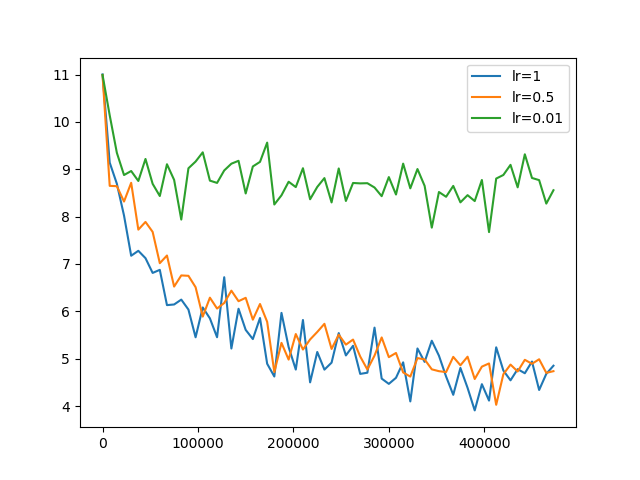

In [12]:
fig, ax = plt.subplots()
for lr, ph in zip(learning_rate, performance_history):
    ax.plot(ph['iter'],ph['loss'],label='lr={:.2g}'.format(lr))
    
ax.legend()

## Finetuning

In [13]:
class AGNewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root='./AG_NEWS/', preprocess=lambda x: x, train=True):
        
        target = 'train.csv' if train else 'test.csv'
        df = pd.read_csv(root + target, header=None, names=['class_idx', 'title', 'description'])
        
        # Etiquetas:
        self.cls_indeces = torch.tensor(df['class_idx'].tolist(), dtype=torch.long) - 1
        
        # DataSeries con las muestras de entradas:
        data = df['title']
        self.data = preprocess(data)
    
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        return self.vectorizer.vectorize(self.data.iloc[idx]), self.cls_indeces[idx]
    
    def __len__(self):
        return len(self.cls_indeces)
    
    
def GetAGNewsDataset(root, preprocess, cutoff=25):
    
    # Datasets:
    train_dataset = AGNewsDataset(root, preprocess=preprocess, train=True)
    train_dataset.vectorizer = Vectorizer([train_dataset.data], cutoff=cutoff)
    test_dataset = AGNewsDataset(root, preprocess=preprocess, train=False)
    test_dataset.vectorizer = train_dataset.vectorizer
    
    # Dataloaders:
    train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset, 
                                                                              test_dataset,    
                                                                              batch_size=64)
    return train_dataloader, val_dataloader, test_dataloader

In [14]:
tc_train_dataloader, tc_val_dataloader, tc_test_dataloader = GetAGNewsDataset(root='./AG_NEWS/', 
                                                                     preprocess=preprocess, 
                                                                     cutoff=25)

import torch.nn as nn

class TextClassifier(nn.Module):
    
    def __init__(self, EmbeddingLayer, n_classes):
        super(TextClassifier, self).__init__()
        self.emb = nn.Linear(EmbeddingLayer.in_features, EmbeddingLayer.out_features)
        self.out = nn.Linear(EmbeddingLayer.out_features, n_classes)
        
    def forward(self, x):
        return self.out(self.emb(x))
    
    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss()
        return lf(scores, target)

In [17]:
# Parámetros de las muestras:
data = {
    'use_gpu': True, # Trasladar o no las muestras a la GPU
    'input_dtype': torch.float, # Tipo de dato de las muestras de entrada
    'target_dtype': torch.long, # Tipo de dato de las muestras de salida
    'train_dataloader': tc_train_dataloader, # Dataset de entrenamiento
    'val_dataloader': tc_val_dataloader # Dataset de validación
}

# Parámetros de optimización:
epochs = 80 # Cantidad de epochs
sample_loss_every = 1000 # Cantidad de iteraciones para calcular la cantidad de aciertos
learning_rate = [2, 1, 1e-1, 1e-2, 1e-3] # Tasa de aprendizaje
check_on_train = False # Queremos ver los resultados también en el train set

# Entrenamiento:
performance_history = []
n_classes = 4
BestEmbeddingModel = models[0]
classification_models = []
ClassifierModel = TextClassifier(BestEmbeddingModel.emb, n_classes)
ClassifierModel.load_state_dict({
    'emb.weight': BestEmbeddingModel.state_dict()['emb.weight'],
    'emb.bias': BestEmbeddingModel.state_dict()['emb.bias'],
    'out.weight': ClassifierModel.state_dict()['out.weight'],
    'out.bias': ClassifierModel.state_dict()['out.bias']
})
for lr in learning_rate:
    model = TextClassifier(BestEmbeddingModel.emb, n_classes)
    model.load_state_dict(ClassifierModel.state_dict())
    for param in model.emb.parameters():
        param.requires_grad = False
    performance_history.append(SGDTrainModel(model, 
                                             data, 
                                             epochs, 
                                             lr, 
                                             sample_loss_every, 
                                             check_on_train, 
                                             verbose=True))
    classification_models.append(model)
    print('lr={:.2g} completed.'.format(lr))

Epoch: 0, Batch number: 0
Accuracy on validation dataset: 1105/2400 (46.04%)

Epoch: 0, Batch number: 1000
Accuracy on validation dataset: 1645/2400 (68.54%)

Epoch: 1, Batch number: 162
Accuracy on validation dataset: 1653/2400 (68.88%)

Epoch: 1, Batch number: 1162
Accuracy on validation dataset: 1677/2400 (69.88%)

Epoch: 2, Batch number: 324
Accuracy on validation dataset: 1656/2400 (69.00%)

Epoch: 2, Batch number: 1324
Accuracy on validation dataset: 1704/2400 (71.00%)

Epoch: 3, Batch number: 486
Accuracy on validation dataset: 1675/2400 (69.79%)

Epoch: 3, Batch number: 1486
Accuracy on validation dataset: 1589/2400 (66.21%)

Epoch: 4, Batch number: 648
Accuracy on validation dataset: 1548/2400 (64.50%)

Epoch: 4, Batch number: 1648
Accuracy on validation dataset: 1691/2400 (70.46%)

Epoch: 5, Batch number: 810
Accuracy on validation dataset: 1613/2400 (67.21%)

Epoch: 5, Batch number: 1810
Accuracy on validation dataset: 1650/2400 (68.75%)

Epoch: 6, Batch number: 972
Accuracy

Epoch: 54, Batch number: 1748
Accuracy on validation dataset: 1645/2400 (68.54%)

Epoch: 55, Batch number: 910
Accuracy on validation dataset: 1611/2400 (67.12%)

Epoch: 56, Batch number: 72
Accuracy on validation dataset: 1620/2400 (67.50%)

Epoch: 56, Batch number: 1072
Accuracy on validation dataset: 1671/2400 (69.62%)

Epoch: 57, Batch number: 234
Accuracy on validation dataset: 1505/2400 (62.71%)

Epoch: 57, Batch number: 1234
Accuracy on validation dataset: 1595/2400 (66.46%)

Epoch: 58, Batch number: 396
Accuracy on validation dataset: 1688/2400 (70.33%)

Epoch: 58, Batch number: 1396
Accuracy on validation dataset: 1605/2400 (66.88%)

Epoch: 59, Batch number: 558
Accuracy on validation dataset: 1642/2400 (68.42%)

Epoch: 59, Batch number: 1558
Accuracy on validation dataset: 1635/2400 (68.12%)

Epoch: 60, Batch number: 720
Accuracy on validation dataset: 1584/2400 (66.00%)

Epoch: 60, Batch number: 1720
Accuracy on validation dataset: 1548/2400 (64.50%)

Epoch: 61, Batch number

Epoch: 29, Batch number: 698
Accuracy on validation dataset: 1714/2400 (71.42%)

Epoch: 29, Batch number: 1698
Accuracy on validation dataset: 1663/2400 (69.29%)

Epoch: 30, Batch number: 860
Accuracy on validation dataset: 1646/2400 (68.58%)

Epoch: 31, Batch number: 22
Accuracy on validation dataset: 1664/2400 (69.33%)

Epoch: 31, Batch number: 1022
Accuracy on validation dataset: 1651/2400 (68.79%)

Epoch: 32, Batch number: 184
Accuracy on validation dataset: 1645/2400 (68.54%)

Epoch: 32, Batch number: 1184
Accuracy on validation dataset: 1588/2400 (66.17%)

Epoch: 33, Batch number: 346
Accuracy on validation dataset: 1666/2400 (69.42%)

Epoch: 33, Batch number: 1346
Accuracy on validation dataset: 1664/2400 (69.33%)

Epoch: 34, Batch number: 508
Accuracy on validation dataset: 1635/2400 (68.12%)

Epoch: 34, Batch number: 1508
Accuracy on validation dataset: 1627/2400 (67.79%)

Epoch: 35, Batch number: 670
Accuracy on validation dataset: 1677/2400 (69.88%)

Epoch: 35, Batch number:

Epoch: 3, Batch number: 1486
Accuracy on validation dataset: 1840/2400 (76.67%)

Epoch: 4, Batch number: 648
Accuracy on validation dataset: 1825/2400 (76.04%)

Epoch: 4, Batch number: 1648
Accuracy on validation dataset: 1831/2400 (76.29%)

Epoch: 5, Batch number: 810
Accuracy on validation dataset: 1822/2400 (75.92%)

Epoch: 5, Batch number: 1810
Accuracy on validation dataset: 1842/2400 (76.75%)

Epoch: 6, Batch number: 972
Accuracy on validation dataset: 1814/2400 (75.58%)

Epoch: 7, Batch number: 134
Accuracy on validation dataset: 1837/2400 (76.54%)

Epoch: 7, Batch number: 1134
Accuracy on validation dataset: 1817/2400 (75.71%)

Epoch: 8, Batch number: 296
Accuracy on validation dataset: 1833/2400 (76.38%)

Epoch: 8, Batch number: 1296
Accuracy on validation dataset: 1818/2400 (75.75%)

Epoch: 9, Batch number: 458
Accuracy on validation dataset: 1843/2400 (76.79%)

Epoch: 9, Batch number: 1458
Accuracy on validation dataset: 1819/2400 (75.79%)

Epoch: 10, Batch number: 620
Accur

Epoch: 58, Batch number: 1396
Accuracy on validation dataset: 1813/2400 (75.54%)

Epoch: 59, Batch number: 558
Accuracy on validation dataset: 1820/2400 (75.83%)

Epoch: 59, Batch number: 1558
Accuracy on validation dataset: 1824/2400 (76.00%)

Epoch: 60, Batch number: 720
Accuracy on validation dataset: 1829/2400 (76.21%)

Epoch: 60, Batch number: 1720
Accuracy on validation dataset: 1826/2400 (76.08%)

Epoch: 61, Batch number: 882
Accuracy on validation dataset: 1818/2400 (75.75%)

Epoch: 62, Batch number: 44
Accuracy on validation dataset: 1818/2400 (75.75%)

Epoch: 62, Batch number: 1044
Accuracy on validation dataset: 1827/2400 (76.12%)

Epoch: 63, Batch number: 206
Accuracy on validation dataset: 1824/2400 (76.00%)

Epoch: 63, Batch number: 1206
Accuracy on validation dataset: 1824/2400 (76.00%)

Epoch: 64, Batch number: 368
Accuracy on validation dataset: 1831/2400 (76.29%)

Epoch: 64, Batch number: 1368
Accuracy on validation dataset: 1828/2400 (76.17%)

Epoch: 65, Batch number

Epoch: 33, Batch number: 346
Accuracy on validation dataset: 1855/2400 (77.29%)

Epoch: 33, Batch number: 1346
Accuracy on validation dataset: 1838/2400 (76.58%)

Epoch: 34, Batch number: 508
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 34, Batch number: 1508
Accuracy on validation dataset: 1857/2400 (77.38%)

Epoch: 35, Batch number: 670
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 35, Batch number: 1670
Accuracy on validation dataset: 1842/2400 (76.75%)

Epoch: 36, Batch number: 832
Accuracy on validation dataset: 1852/2400 (77.17%)

Epoch: 36, Batch number: 1832
Accuracy on validation dataset: 1856/2400 (77.33%)

Epoch: 37, Batch number: 994
Accuracy on validation dataset: 1846/2400 (76.92%)

Epoch: 38, Batch number: 156
Accuracy on validation dataset: 1855/2400 (77.29%)

Epoch: 38, Batch number: 1156
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 39, Batch number: 318
Accuracy on validation dataset: 1850/2400 (77.08%)

Epoch: 39, Batch number

Epoch: 7, Batch number: 1134
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 8, Batch number: 296
Accuracy on validation dataset: 1849/2400 (77.04%)

Epoch: 8, Batch number: 1296
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 9, Batch number: 458
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 9, Batch number: 1458
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 10, Batch number: 620
Accuracy on validation dataset: 1841/2400 (76.71%)

Epoch: 10, Batch number: 1620
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 11, Batch number: 782
Accuracy on validation dataset: 1846/2400 (76.92%)

Epoch: 11, Batch number: 1782
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 12, Batch number: 944
Accuracy on validation dataset: 1846/2400 (76.92%)

Epoch: 13, Batch number: 106
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 13, Batch number: 1106
Accuracy on validation dataset: 1845/2400 (76.88%)

Epoch: 14, Batch number: 26

Epoch: 62, Batch number: 1044
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 63, Batch number: 206
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 63, Batch number: 1206
Accuracy on validation dataset: 1850/2400 (77.08%)

Epoch: 64, Batch number: 368
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 64, Batch number: 1368
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 65, Batch number: 530
Accuracy on validation dataset: 1850/2400 (77.08%)

Epoch: 65, Batch number: 1530
Accuracy on validation dataset: 1851/2400 (77.12%)

Epoch: 66, Batch number: 692
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 66, Batch number: 1692
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 67, Batch number: 854
Accuracy on validation dataset: 1849/2400 (77.04%)

Epoch: 68, Batch number: 16
Accuracy on validation dataset: 1848/2400 (77.00%)

Epoch: 68, Batch number: 1016
Accuracy on validation dataset: 1847/2400 (76.96%)

Epoch: 69, Batch number

<IPython.core.display.Javascript object>


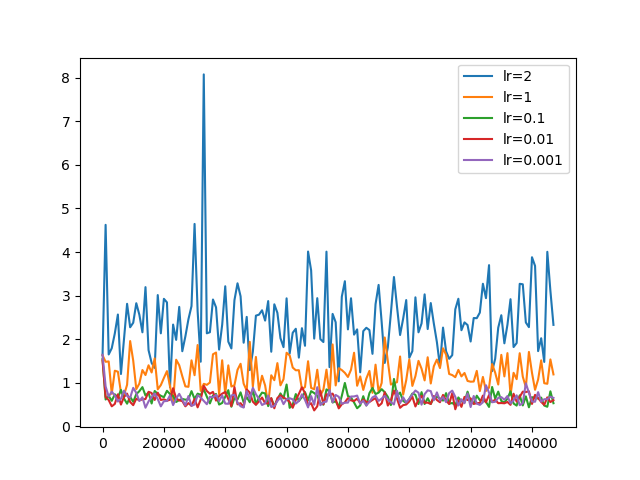

In [18]:
fig, ax = plt.subplots()
for lr, ph in zip(learning_rate, performance_history):
    ax.plot(ph['iter'],ph['loss'],label='lr={:.2g}'.format(lr))
    
ax.legend()